# Load drive & other fastai libs

https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev_course/dl2/pascal.ipynb

https://competitions.codalab.org/competitions/23177

In [0]:
# only on google colab
!curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

# Start work

## Get path

In [0]:
path = Path("/content/drive/My Drive/data/sorghum_train_public")
path.ls()

[PosixPath('/content/drive/My Drive/data/sorghum_train_public/sample_test_images'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/train_labelled_images'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/train_labelled_annotations'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/train_unlabelled_images'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/.DS_Store'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/stage-2-256-export'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/.ipynb_checkpoints'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/test_images'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/test_result'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/models-21-jun-mAP-02'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/models-24jun-mAP-012'),
 PosixPath('/content/drive/My Drive/data/sorghum_train_public/stage1-export'),


In [0]:
path_train = path/'train_labelled_images'
path_test = path/'train_unlabelled_images'
path_annot = path/'train_labelled_annotations'

## Coco path

In [0]:
# coco_path = untar_data(URLs.PASCAL_2007)
# import json
# annots = json.load(open(coco_path/'train.json'))
# annots.items()

Fastai uses coco format. It is  ,bboxes: list of bboxes (each of those being four integers with the top, left, bottom, right convention)


This competition uses left-top- right-bottom

Required:
```
train_images[1], train_lbl_bbox[1]

('000017.jpg',
 [[[61, 184, 199, 279], [77, 89, 336, 403]], ['person', 'horse']])
```

## Convert annotation file to fastai annotation format


In [0]:
annot = path_annot/"01e768fb5d8961370b9a6d4377296f379fcd6873.txt"
print(annot.open().read()[:200])

sorghumHeadyieldTrail 0 150 20 170
sorghumHeadyieldTrail 0 337 15 356
sorghumHeadyieldTrail 3 254 35 282
sorghumHeadyieldTrail 3 452 21 470
sorghumHeadyieldTrail 6 608 33 631
sorghumHeadyieldTrail 8 6


In [0]:
labels = []
images = []
for pth in path_annot.glob("**/*.txt"):
    print('\r Processing {}'.format(pth.name), end=" " )
    with pth.open() as fhand:
        box = []
        cat = []
        for line in fhand.readlines():
            coord = line.strip().split(" ")[-4:]
            coord = list(map(int, coord))
            coord = [coord[1], coord[0], coord[3], coord[2]]
            box.append(coord)
            cat.append(0)
        labels.append([box, cat])
        images.append(pth.stem + ".jpeg")
# print(labels[0])


 Processing C18-R38-G528-DSC01775.txt 

In [0]:
len(images), images[0], len(labels[0][0]), len(labels[0][1])

(300, 'C13-R34-G401-DSC01544.jpeg', 106, 106)

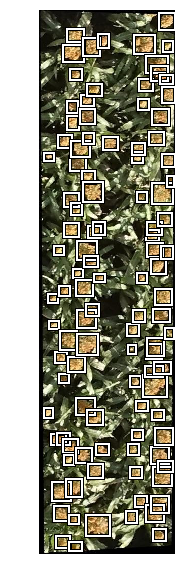

In [0]:
img = open_image(path_train/images[0])
bbox = ImageBBox.create(*img.size, labels[0][0],classes=['0'])
img.show(figsize=(15,10), y=bbox)

In [0]:
img2bbox = dict(zip(images, labels))
get_y_func = lambda o:img2bbox[o.name]

def get_data(bs, size):
    src = ObjectItemList.from_folder(path_train)
    src = src.split_by_rand_pct(seed=42) 
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [0]:
data = get_data(64,128)
# data.show_batch(rows=3)

# RetinaNet with FPN

In [0]:
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')
    
    
    
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [0]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))


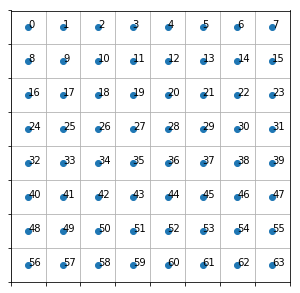

In [0]:
size = (8,8)
show_anchors(create_grid(size), size)

In [0]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors


In [0]:
sizes=[(32, 32), (16, 16), (8, 8), (4, 4), (2, 2)]
ratios=[0.5, 1, 2]
scales=[0.35, 0.5, 1]
anchors = create_anchors(sizes, ratios, scales)

In [0]:
anchors.size()


torch.Size([12276, 4])

In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

    
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])



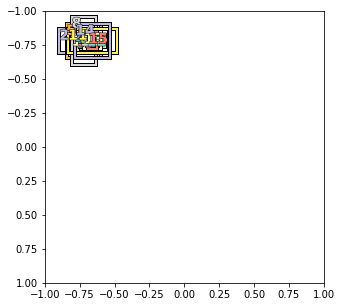

In [0]:
show_boxes(anchors[900:916])

In [0]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [0]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = torch.randn(size[0]*size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)


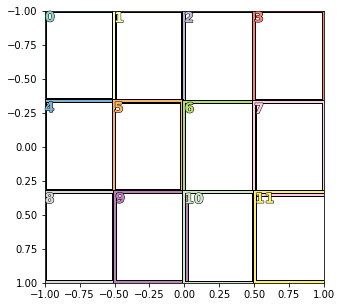

In [0]:
show_boxes(bboxes)

In [0]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

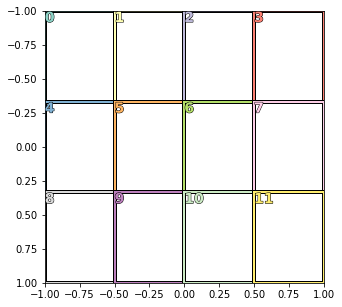

In [0]:
show_boxes(anchors)

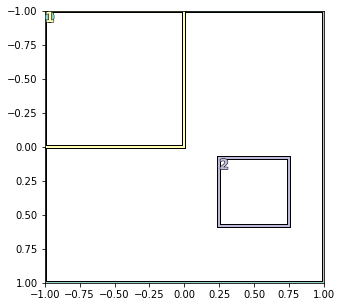

In [0]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [0]:
intersection(anchors, targets)


tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [0]:
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [0]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

In [0]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches


In [0]:
match_anchors(anchors, targets)


tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [0]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [0]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)


tensor([ 0,  1,  2,  3, -2])

In [0]:
def tlbr2cthw(boxes):
    """Convert top/left bottom/right format `boxes` to center/size corners. 
    Does the opposite of cthw2tbr."""
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

def bbox_to_activ(bboxes, anchors, flatten=True):
    """Return the target of the model on `anchors` for the `bboxes`. 
    Does the opposite of activ_to_bbox."""
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [0]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [0]:
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

    
    
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()


In [0]:
# sizes=[(32,32),(16,16),(8,8),(4,4)]
ratios=[0.5, 1, 2]
scales=[0.35, 0.5, 1]
sizes

[(32, 32), (16, 16), (8, 8), (4, 4), (2, 2)]

In [0]:
encoder = create_body(models.resnet18, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit, )

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 79316573.33it/s]


In [0]:
torch.sigmoid(tensor([-4.]))


tensor([0.0180])

In [0]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]


# Start Learning

In [0]:
learn = learn.split(retina_net_split)

In [0]:
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(skip_end=5)


## Stage1-128

In [0]:
lr = 1e-4

learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,3.575378,3.398480,03:23
1,3.106690,1.760888,03:03
2,2.955780,2.683110,03:03
3,2.777269,2.778185,03:02
4,2.688142,2.739255,03:03


In [0]:
learn.save('stage1-128')


## Stage2-128

In [0]:
learn = learn.load('stage1-128')
learn.unfreeze()


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LateralUpsampleMerge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNetFocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:

learn.fit_one_cycle(20, slice(1e-6, 5e-5))
learn.save('stage2-128')
learn.export("stage2-export")

epoch,train_loss,valid_loss,time
0,2.360479,2.645522,03:08
1,2.298422,2.413104,03:08
2,2.172795,1.919703,03:06
3,2.088380,1.636418,03:06
4,2.027301,1.766715,03:07
5,1.948403,1.658433,03:07
6,1.873131,1.421611,03:07
7,1.804852,1.384560,03:07
8,1.738626,1.331448,03:05
9,1.677715,1.250109,03:07


In [0]:
# learn = learn.load('stage2')

## stage1-192

In [0]:
learn.data = get_data(32,192)
learn.freeze()
# learn.lr_find()
# learn.recorder.plot()


In [0]:

learn.fit_one_cycle(5, 1e-4)
learn.save('stage1-192')


In [0]:
learn.fit_one_cycle(10, 1e-4)
learn.save('stage1-192')

In [0]:
# learn = learn.load('stage1-192')

## stage2-192

In [0]:
learn = learn.load('stage1-192')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LateralUpsampleMerge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNetFocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
learn.unfreeze()

In [0]:
# for i in range(10):
learn.fit_one_cycle(15, slice(1e-6, 5e-5))
learn.save('stage2-192')
    
learn.export('Export-stage2-192')

epoch,train_loss,valid_loss,time
0,1.074595,1.185652,03:46
1,1.041367,1.099700,03:16
2,1.001981,0.943630,03:15
3,0.985869,0.898028,03:16
4,0.959933,0.923534,03:16
5,0.943294,0.880421,03:14
6,0.926036,0.853624,03:14
7,0.912485,0.844711,03:14
8,0.901179,0.825143,03:15
9,0.888565,0.824059,03:14


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNetFocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LateralUpsampleMerge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# learn = learn.load('stage2-192')

In [0]:
# len(learn.layer_groups)

## stage1-256



---



---



In [0]:
learn.freeze()
learn.data = get_data(24,256)

In [0]:
learn.fit_one_cycle(10, 1e-4)
learn.save('stage1-256')

epoch,train_loss,valid_loss,time
0,1.385306,0.849460,14:37
1,1.206158,0.883641,14:40
2,1.078947,0.741167,14:37
3,0.983376,0.664799,14:35
4,0.909452,0.661018,14:38
5,0.854733,0.640433,14:30
6,0.812595,0.633906,14:34
7,0.777762,0.620621,14:41
8,0.753917,0.613633,14:39
9,0.734574,0.614105,14:38


In [0]:
# learn.data = get_data(24,256)
# learn = learn.load('stage1-256')

## stage2-256

In [0]:

learn.unfreeze()


In [0]:

learn.fit_one_cycle(10, slice(1e-6, 5e-5))
learn.save('stage2-256')
    
    
learn.export("Export-stage2-256")

epoch,train_loss,valid_loss,time
0,0.661963,0.605645,15:11
1,0.662061,0.594028,15:02
2,0.656513,0.580965,15:04
3,0.647512,0.579834,15:09
4,0.640228,0.579360,15:12
5,0.630224,0.563284,15:13


# Results

In [112]:
learn = learn.load('stage2-256')
learn.data = get_data(24,256)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LateralUpsampleMerge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNetFocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = learn.model(img)
    
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

def process_output(output, i, detect_thresh=0.25):
    "Process `output[i]` and return the predicted bboxes above `detect_thresh`."
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
#     for bbox in bbox_pred:
#         bbox[2] /= 2
#         bbox[3] /= 2
    
    return bbox_pred, scores, preds

def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)
        
def show_preds(img, output, idx, detect_thresh=0.25, classes=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    bbox_pred, preds, scores = bbox_pred.cpu(), preds.cpu(), scores.cpu()
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    _, ax = plt.subplots(1,1)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

And let's have a look at one picture.

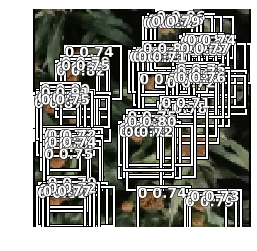

In [114]:

idx = 0
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.7, classes=data.classes)

# NMS
It looks like a lot of our anchors are detecting kind of the same object. We use an algorithm called Non-Maximum Suppression to remove near-duplicates: going from the biggest score predicted to the lowest, we take the corresponding bounding boxes and remove all the bounding boxes down the list that have an IoU > 0.5 with this one. We continue the process until we have reached the end of the list.

In [0]:
def nms(boxes, scores, thresh=0.35):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)


# def process_output(output, i, detect_thresh=0.25):
#     clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
#     anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
#     bbox_pred = activ_to_bbox(bbox_pred, anchors)
#     clas_pred = torch.sigmoid(clas_pred)
#     detect_mask = clas_pred.max(1)[0] > detect_thresh
#     bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
#     bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
#     if clas_pred.numel() == 0: return [],[],[]
#     scores, preds = clas_pred.max(1)
#     return bbox_pred, scores, preds



def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')
        
        
def show_results(learn, start=0, n=5, detect_thresh=0.35, figsize=(10,25)):
    x,y = learn.data.one_batch(DatasetType.Valid, cpu=False)
    with torch.no_grad():
        z = learn.model.eval()(x)
    _,axs = plt.subplots(n, 2, figsize=figsize)
    for i in range(n):
        img,bbox = learn.data.valid_ds[start+i]
        img.show(ax=axs[i,0], y=bbox)
        show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs[i,1])

In [0]:
# learn = learn.load('stage2-256')

## valid output

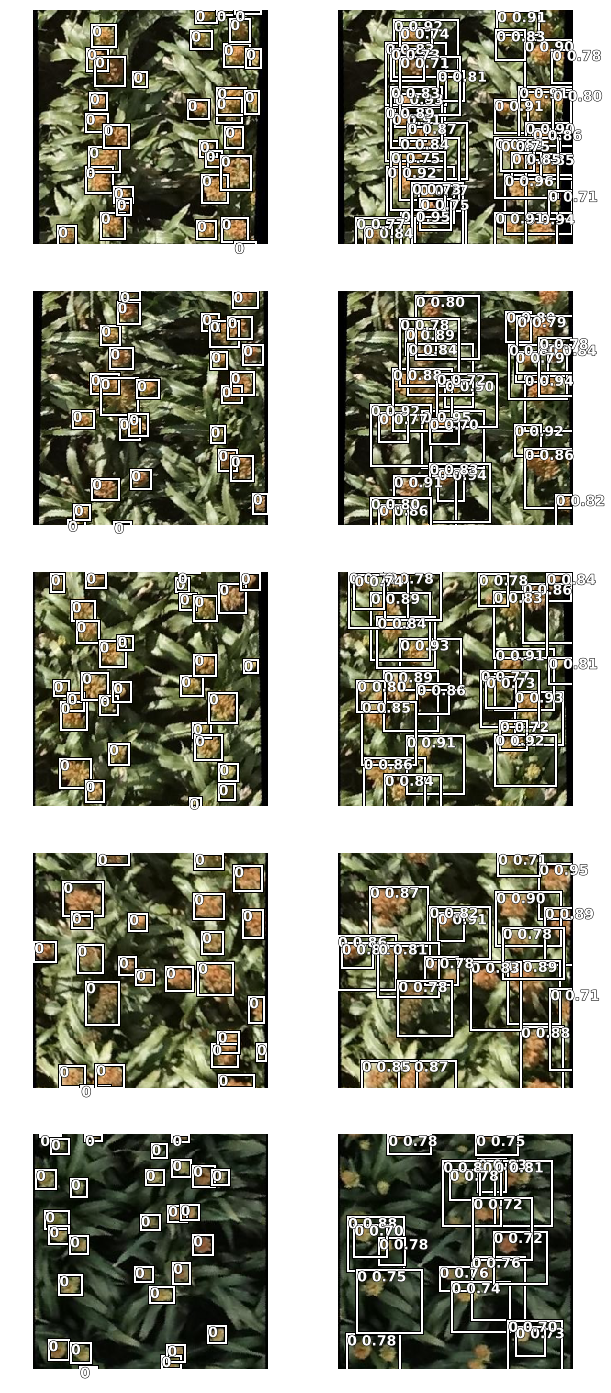

In [117]:
show_results(learn, start=10, detect_thresh=0.7, )

# Test

In [0]:
# preds = learn.predict(img.data)

def no_tfms(self, x, *args, **kwargs): return x
EmptyLabel.apply_tfms = no_tfms

def get_test_data(bs, size):
    src = ObjectItemList.from_folder(path_train)
    src = src.split_by_rand_pct(seed=42) 
    src = src.label_from_func(get_y_func)
    src = src.add_test(ItemList.from_folder(path_test),label=None)
    src = src.transform(get_transforms(),  size=size, 
                        tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [0]:
learn.data = get_test_data(24,256)  
# learn.data.single_ds.tfmargs['size'] = None

In [0]:

        
def show_test_results(learn, oimg=img, start=0, n=1, detect_thresh=0.35, nms_thresh=0.3, figsize=(10,25), classes=learn.data.classes):
#     import pdb; pdb.set_trace()
#     x,y = learn.data.one_batch(DatasetType.Valid, cpu=False)
    x = learn.data.one_item(oimg)[0]
    with torch.no_grad():
        z = learn.model.eval()(x)
    _,axs = plt.subplots(1, 2, figsize=figsize)
    axs = axs.reshape(1,2)
    
    
    oimg.show(ax=axs[0,0])
    
    img, oimg, output, idx = x, oimg, z, start
    
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores, thresh=nms_thresh)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*oimg.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    ax=axs[0,1]
    oimg.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3]/2,bbox[2]/2], text=f'{scr:.2f}')

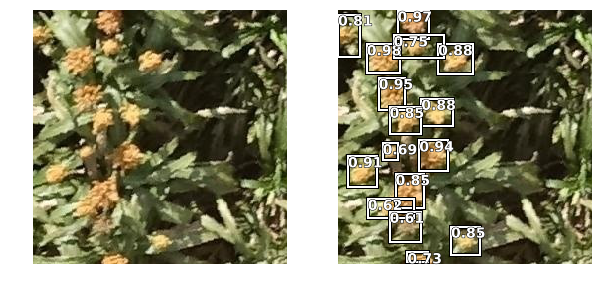

In [121]:
img = open_image('/content/drive/My Drive/data/sorghum_train_public/train_unlabelled_images/C1-R12-missing-DSC00877.jpeg')

crop(img,256)
show_test_results(learn, img, start=0, detect_thresh=0.60, nms_thresh=0.10)

`0.7` Threshold looks good. But boxes are big in size. 

show_test_results(learn, img, start=0, detect_thresh=0.70, nms_thresh=0.35)

# Check load_learner can be used   - DONE


---



We already have exported the file `Export-stage2-256`. We will load it.

In [0]:
tlearn = load_learner(path,'Export-stage2-256')

In [0]:
tlearn.data.single_ds.tfmargs['size'] = None

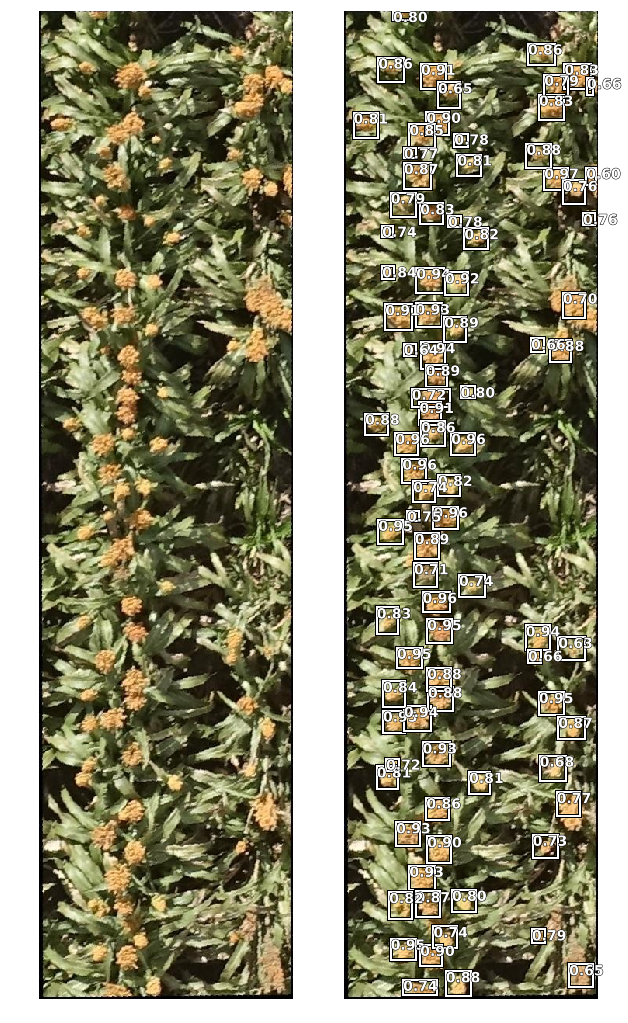

In [124]:
img = open_image('/content/drive/My Drive/data/sorghum_train_public/train_unlabelled_images/C1-R12-missing-DSC00877.jpeg')

show_test_results(tlearn, img, start=0, detect_thresh=0.60, nms_thresh=0.10)

learner with export file is working. We will use it in separate file.

# mAP

In [125]:
learn = learn.load('stage2-256')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LateralUpsampleMerge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNetFocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

def get_predictions(output, idx, detect_thresh=0.05, nms_thresh=0.35):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores, thresh=nms_thresh)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]


def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, nms_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        for input,target in progress_bar(dl):
            output = model(input)
            for i in range(target[0].size(0)):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh, nms_thresh)
#                 for bbox in bbox_pred :
#                     bbox[3] =bbox[3]/2
#                     bbox[2] =bbox[2]/2
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                    ious = IoU_values(bbox_pred, tgt_bbox)
                    max_iou, matches = ious.max(1)
                    detected = []
                    for i in range_of(preds):
                        if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                            detected.append(matches[i])
                            tps.append(1)
                        else: tps.append(0)
                    clas.append(preds.cpu())
                    p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    #return tps, clas
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [127]:
L = compute_class_AP(learn.model, data.valid_dl, data.c-1, detect_thresh=0.60, nms_thresh=0.1)


In [128]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}')


0: 0.153420
